## Import Libraries

In [35]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

%matplotlib inline

## Load the Data

In [36]:
df = pd.read_csv("final_data.csv")

In [37]:
df.shape

(10754, 22)

In [38]:
df.head(2)

,player,team,name,position,height,age,appearance,goals,assists,yellow cards,...,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger
0,/david-de-gea/profil/spieler/59377,Manchester United,David de Gea,Goalkeeper,189.0,32.0,104,0.0,0.0,0.009585,...,1.217252,0.335463,9390,42,5,13,15000000,70000000,1,0
1,/jack-butland/profil/spieler/128899,Manchester United,Jack Butland,Goalkeeper,196.0,30.0,15,0.0,0.0,0.069018,...,1.242331,0.207055,1304,510,58,1,1500000,22000000,1,0


## Preprocess the Data

#### 1. Simple EDA + Data Quality checking

In [39]:
# uniqeness
df.drop_duplicates(inplace=True)
df[df.duplicated()]

,player,team,name,position,height,age,appearance,goals,assists,yellow cards,...,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger


In [40]:
# Function to clean and extract the desired format
def clean_player_name(url):
    try:
        parts = url.split('/')
        if len(parts) > 2 and parts[-1].isdigit():  # Check if the last part is a number
            name = parts[1]  # Extract the name part between the first and second slashes
            number = parts[-1]  # Extract the number at the end
            return f"{name}-{number}"  # Return the name and number separated by a dash
        else:
            return None  # Return None for invalid structure
    except Exception as e:
        return None  # Handle cases where the structure doesn't match

# Apply the cleaning function to the 'player' column and overwrite it
df['player'] = df['player'].apply(clean_player_name)

# Verify the result
print(df[['player']].head())

                     player
0        david-de-gea-59377
1       jack-butland-128899
2          tom-heaton-34130
3  lisandro-martinez-480762
4     raphael-varane-164770


In [41]:
# Completeness
df.isnull().sum()

player                 0
team                   0
name                   0
position               0
height                 0
age                    0
appearance             0
goals                  0
assists                0
yellow cards           0
second yellow cards    0
red cards              0
goals conceded         0
clean sheets           0
minutes played         0
days_injured           0
games_injured          0
award                  0
current_value          0
highest_value          0
position_encoded       0
winger                 0
dtype: int64

In [42]:
# Accurecy types
df.dtypes

player                  object
team                    object
name                    object
position                object
height                 float64
age                    float64
appearance               int64
goals                  float64
assists                float64
yellow cards           float64
second yellow cards    float64
red cards              float64
goals conceded         float64
clean sheets           float64
minutes played           int64
days_injured             int64
games_injured            int64
award                    int64
current_value            int64
highest_value            int64
position_encoded         int64
winger                   int64
dtype: object

In [43]:
# Accurecy - Outlier

# Convert categorical variables using OneHotEncoding
categorical_features = ['player', 'team', 'name', 'position']
numeric_features = ['height', 'age', 'appearance', 'goals', 'assists', 'yellow cards', 'second yellow cards', 'red cards', 'goals conceded'
                   , 'clean sheets', 'minutes played', 'days_injured', 'games_injured', 'award', 'current_value', 'highest_value', 'position_encoded', 'winger']

In [44]:
# for i in categorical_features:
#     print (df[i].value_counts())

In [45]:
# Calculate the frequency of each 'Type'
type_counts = df['team'].value_counts()

# Filter 'Type' values that appear 10 or more times
df = df[df['team'].isin(type_counts[type_counts >= 2].index)]

In [46]:
df.shape

(10754, 22)

In [47]:
df.describe()

,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger
count,10754.000000,10754.000000,10754.000000,10754.000000,10754.000000,10754.000000,10754.000000,10754.000000,10754.000000,10754.000000,10754.000000,10754.000000,10754.000000,10754.000000,1.075400e+04,1.075400e+04,10754.000000,10754.000000
mean,181.240353,26.041903,36.407011,0.125554,0.086978,0.189757,0.004666,0.006826,0.131655,0.044881,2470.789381,117.961689,15.826297,1.960759,3.622971e+06,6.152606e+06,2.713223,0.307513
std,6.969818,4.777629,26.526541,0.235585,0.143351,0.432388,0.025232,0.081143,0.442335,0.924437,2021.703271,175.206827,23.383606,3.743936,9.095410e+06,1.338988e+07,0.986356,0.461485
min,156.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,1.000000,0.000000
25%,176.000000,22.000000,12.000000,0.000000,0.000000,0.053191,0.000000,0.000000,0.000000,0.000000,660.000000,0.000000,0.000000,0.000000,3.000000e+05,4.500000e+05,2.000000,0.000000
50%,181.240353,26.000000,35.000000,0.045969,0.040773,0.150250,0.000000,0.000000,0.000000,0.000000,2101.500000,37.000000,5.000000,1.000000,8.000000e+05,1.500000e+06,3.000000,0.000000
75%,186.000000,29.000000,59.000000,0.172263,0.133136,0.248276,0.000000,0.000000,0.000000,0.000000,3968.000000,181.000000,24.000000,2.000000,3.000000e+06,5.000000e+06,4.000000,1.000000
max,206.000000,43.000000,107.000000,11.250000,4.000000,30.000000,1.000000,6.923077,9.000000,90.000000,9510.000000,2349.000000,339.000000,92.000000,1.800000e+08,2.000000e+08,4.000000,1.000000


In [48]:
import numpy as np
import pandas as pd

# Function to remove outliers based on a moderately strict Interquartile Range (IQR) method
def remove_outliers(df, column, factor=1.25):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    # Return the dataframe without outliers for the column
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]


# Identify all numeric columns
numeric_columns = df.select_dtypes(include=[np.number]).columns

# Store original shape before removing outliers
print("Original shape:", df.shape)

# Remove outliers from all numeric columns using a moderately strict IQR factor
for column in numeric_columns:
    df = remove_outliers(df, column, factor=1.25)  # Moderately strict outlier removal

# Print shape after removing outliers
print("Shape after removing outliers:", df.shape)


Original shape: (10754, 22)
Shape after removing outliers: (3660, 22)


#### 2. Feature engineering

1. Feature scaling
2. Aggregation
3. One hot coding

In [49]:
df.head(2)

,player,team,name,position,height,age,appearance,goals,assists,yellow cards,...,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger
8,teden-mengi-548470,Manchester United,Teden Mengi,Defender Centre-Back,186.0,21.0,34,0.000000,0.000000,0.130529,...,0.0,0.0,2758,47,13,0,2000000,2000000,2,0
20,zidane-iqbal-686845,Manchester United,Zidane Iqbal,midfield-CentralMidfield,181.0,20.0,39,0.129125,0.064562,0.225968,...,0.0,0.0,2788,0,0,1,800000,800000,3,0


In [50]:
categorical_features

['player', 'team', 'name', 'position']

In [51]:
# one hot coding
df = pd.get_dummies(df, columns=categorical_features)

In [52]:
df.shape

(3660, 7680)

In [53]:
df.head(2)

,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,...,position_Defender Centre-Back,position_Defender Left-Back,position_Defender Right-Back,position_Goalkeeper,position_midfield,position_midfield-AttackingMidfield,position_midfield-CentralMidfield,position_midfield-DefensiveMidfield,position_midfield-LeftMidfield,position_midfield-RightMidfield
8,186.0,21.0,34,0.000000,0.000000,0.130529,0.0,0.0,0.0,0.0,...,True,False,False,False,False,False,False,False,False,False
20,181.0,20.0,39,0.129125,0.064562,0.225968,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,True,False,False,False


In [54]:
df.describe()

,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger
count,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.000000,3660.0,3660.0,3660.0,3660.0,3660.000000,3660.000000,3660.000000,3660.000000,3.660000e+03,3.660000e+03,3660.000000,3660.000000
mean,179.774653,24.621722,24.789617,0.069785,0.051440,0.139866,0.0,0.0,0.0,0.0,1585.567760,40.551913,5.035246,0.632514,6.245751e+05,8.071284e+05,2.774044,0.361475
std,6.364072,4.399070,22.072417,0.100259,0.071560,0.132114,0.0,0.0,0.0,0.0,1563.030807,73.051389,8.834305,0.992281,6.852106e+05,8.087828e+05,0.868528,0.480494
min,164.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,1.000000,0.000000
25%,175.000000,21.000000,6.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,270.000000,0.000000,0.000000,0.000000,1.500000e+05,2.000000e+05,2.000000,0.000000
50%,180.000000,24.000000,17.000000,0.000000,0.000000,0.125698,0.0,0.0,0.0,0.0,1093.000000,0.000000,0.000000,0.000000,4.000000e+05,5.000000e+05,3.000000,0.000000
75%,184.000000,28.000000,42.000000,0.112597,0.093634,0.232784,0.0,0.0,0.0,0.0,2580.750000,53.250000,7.000000,1.000000,8.000000e+05,1.000000e+06,3.000000,1.000000
max,198.000000,37.000000,96.000000,0.388454,0.273141,0.497238,0.0,0.0,0.0,0.0,7199.000000,386.000000,38.000000,4.000000,3.000000e+06,3.000000e+06,4.000000,1.000000


#### 3. Feature selection

In [55]:
# sns.heatmap(df.corr(), annot=True);

In [56]:
correlation = df.corr()
print(correlation['current_value'].sort_values(ascending=False))

current_value          1.000000
highest_value          0.863160
minutes played         0.361456
appearance             0.355338
assists                0.223607
                         ...   
position_Goalkeeper   -0.141388
second yellow cards         NaN
red cards                   NaN
goals conceded              NaN
clean sheets                NaN
Name: current_value, Length: 7680, dtype: float64


In [57]:
# Set the correlation threshold
threshold = 0.2  # You can change this value based on your requirement

# Filter the correlations
# We use `abs()` for absolute value to consider both strong positive and negative correlations
selected_features = correlation[abs(correlation['current_value']) > threshold]['current_value'].index
selected_features

Index(['appearance', 'assists', 'minutes played', 'current_value',
       'highest_value'],
      dtype='object')

In [60]:
selected_features = ['appearance', 'assists', 'minutes played',
                     'current_value', 
                      'highest_value']

In [61]:
df = df[selected_features]
df.head()

,appearance,assists,minutes played,current_value,highest_value
8,34,0.000000,2758,2000000,2000000
20,39,0.064562,2788,800000,800000
21,51,0.102506,3512,800000,800000
118,38,0.074257,2424,500000,500000
241,49,0.080972,2223,600000,600000


#### 4. Prepare train and test data

In [62]:
# Prepare data
X = df.drop(['current_value'], axis=1)
y = df['current_value']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=42)

# sacle the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [63]:
X.shape

(3660, 4)

## Buliding the Model

In [64]:
model = LinearRegression()

In [65]:
ridge_model = Ridge()  # You can adjust alpha to see different resu

In [66]:
lasso_model = Lasso()  # You can adjust alpha to see different results

In [67]:
param_grid = {
    'alpha': [0, 0.0000003, 0.0002, 0.001, 0.01, 0.5, 1, 5]  # Regularization strength
}
grid_search = GridSearchCV(estimator=ridge_model,
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error', 
                           verbose=1)

grid_search_lasso = GridSearchCV(estimator=lasso_model,
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error', 
                           verbose=1)

## Train the Model

In [69]:
# Fit the model on the training data
model.fit(X_train_scaled, y_train)

LinearRegression()

## Test the Model

In [70]:
# Predict and evaluate the model
y_pred = model.predict(X_test_scaled)

## Interpretation of the Model

In [71]:
coeff_df = pd.DataFrame(model.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
appearance,-73650.467023
assists,19864.293464
minutes played,96257.958596
highest_value,579005.656031


In [72]:
print(model.intercept_) 

616653.0054644808


In [75]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Lasso model
lasso_model = Lasso()

# Train the Lasso model
lasso_model.fit(X_train, y_train)

# Now you can access the coefficients
coeff_df = pd.DataFrame(lasso_model.coef_, X.columns, columns=['Coefficient'])

# Display the coefficients
print(coeff_df)


                  Coefficient
appearance       -3341.682077
assists         277170.040779
minutes played      61.696497
highest_value        0.718352


## Evaluating the Model 

1. Mean Square Error

In [76]:
y_base = [y_train.mean()] * len(y_test)

In [77]:
# our benchmark model
mse_base = mean_squared_error(y_test, y_base )
print(f'Mean Squared Error of base model: {mse_base}')

Mean Squared Error of base model: 464779736443.30975


In [78]:
mse_train = mean_squared_error(y_train, model.predict(X_train_scaled))
mse_test = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error for training: {mse_train}')
print(f'Mean Squared Error for testing: {mse_test}')

Mean Squared Error for training: 119094919879.9946
Mean Squared Error for testing: 112819278011.51048


2. Mean Absolute Error

In [79]:
# our benchmark model
mse_base = mean_absolute_error(y_test, y_base )
print(f'Mean Absolute  Error of base model: {mse_base}')

Mean Absolute  Error of base model: 497739.6682492758


In [80]:
mae_train = mean_absolute_error(y_train, model.predict(X_train_scaled))
mae_test = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error for training: {mae_train}')
print(f'Mean Absolute Error for testing: {mae_test}')

Mean Absolute Error for training: 198259.06173750904
Mean Absolute Error for testing: 199187.3744065326


3. Root Mean Squared Error

In [81]:
# our benchmark model
print(f'Root Mean Squared  Error of base model: {np.sqrt(mse_base)}')

Root Mean Squared  Error of base model: 705.5066748438854


In [82]:
print(f'Root Mean Squared Error for training: {np.sqrt(mse_train)}')
print(f'Root Mean Squared Error for testing: {np.sqrt(mse_test)}')

Root Mean Squared Error for training: 345101.3182820295
Root Mean Squared Error for testing: 335885.8109707978


4. R Square

In [83]:
r2_score_train = r2_score(y_train, model.predict(X_train_scaled))
r2_score_test = r2_score(y_test, y_pred)
print(f'R Square for training: {r2_score_train}')
print(f'R Square for testing: {r2_score_test}')

R Square for training: 0.7469377578605743
R Square for testing: 0.7564407080377791


#### Predictions vs. Real Values

In [84]:
predictions = model.predict(X_test_scaled)
#predictions

In [85]:
Real_Values = np.array(y_test)
#Real_Values

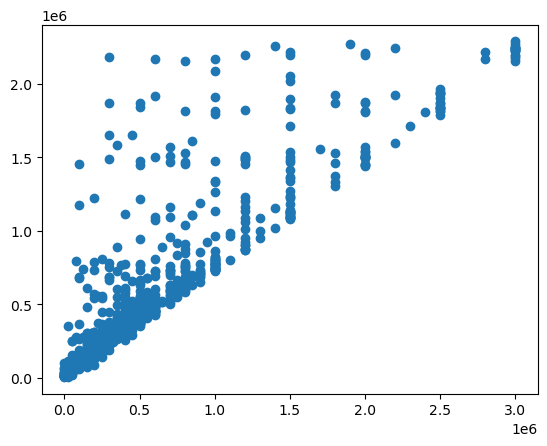

In [86]:
plt.scatter(Real_Values,predictions); 

#### Residual Histogram

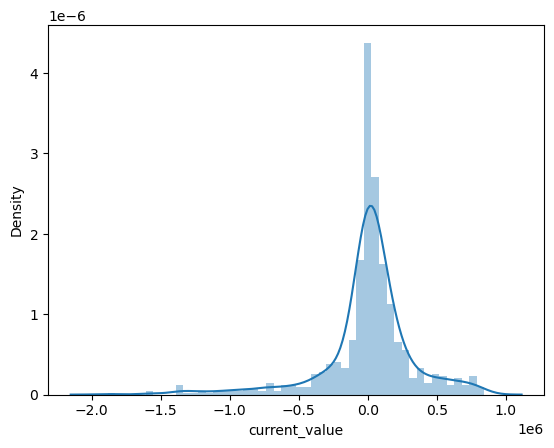

In [87]:
sns.distplot((y_test-predictions),bins=50); # it's good if we get normal distribution